In [75]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit,linprog

In [76]:
# EV_eff_table = pd.read_csv("Electric Motor Efficiency.csv")
# IC_eff_table = pd.read_csv("IC Motor Efficiency.csv")

# EV_eff_arr = np.array(EV_eff_table).astype(float)
# IC_eff_arr = np.array(EV_eff_table).astype(float)

# EV_eff_df = pd.DataFrame.set_index(EV_eff_table,['Speed (RPM)','Torque (Nm)'])
# IC_eff_df = pd.DataFrame.set_index(IC_eff_table,['Speed (RPM)','Torque (Nm)'])

In [77]:
# Generate efficiency curves

# x = EV_eff_arr[:,0]
# y = EV_eff_arr[:,1]
# z = EV_eff_arr[:,2]

# # Creating figure
# fig = plt.figure(figsize =(14, 9))
# ax = plt.axes(projection ='3d')
 
# # Creating plot
# ax.scatter(x, y, z)
 
# # show plot
# plt.show()

In [78]:
route = pd.read_csv("data/route1.csv")
ts = np.array(route['Time(s)'])
ts = ts.reshape(-1,1)
Ps = np.array(route['Power(kW)'])
Ps = Ps.reshape(-1,1)

duplicate = 2
for _ in range(1): # duplicate
    t0 = ts[-1]
    ts = np.concatenate((ts,ts + ts[-1]))
    route = np.concatenate((route,route))
    

In [79]:
route = pd.read_csv("data/route1.csv")
ts = np.array(route['Time(s)'])
# ts = ts.reshape(-1,1)
Ps = np.array(route['Power(kW)'])
# Ps = Ps.reshape(-1,1)

duplicate = 2
for _ in range(1): # duplicate
    t0 = ts[-1]
    ts = np.concatenate((ts,ts + ts[-1]))
    Ps = np.concatenate((Ps,Ps))

# set parameters
# Power outputs
EV_discharge_lim = 80 #kW
EV_charge_lim = 60 #kW
IC_power_lim = 150 #kW

# Efficiency curves not used yet
EV_in_eff = 0.5
EV_out_eff = 0.9
IC_eff = 0.35

# Starting charge
charge_max = 1000
charge_0 = 20

# costs
fuel_cost = 1
battery_cost = 0.01

# Set up linear optimisation
intervals = np.size(Ps,0)

f = np.concatenate((battery_cost*np.ones(intervals),battery_cost*np.ones(intervals),fuel_cost*np.ones(intervals)))

A = np.concatenate(
    (np.concatenate((EV_out_eff*np.tril(np.ones([intervals,intervals])),-EV_in_eff*np.tril(np.ones([intervals,intervals])),np.zeros([intervals,intervals])),1),
     np.concatenate((-EV_out_eff*np.tril(np.ones([intervals,intervals])),EV_in_eff*np.tril(np.ones([intervals,intervals])),np.zeros([intervals,intervals])),1),
     np.concatenate((-EV_out_eff*np.eye(intervals),EV_in_eff*np.eye(intervals),-IC_eff*np.eye(intervals)),1))
     ,0)

b = np.concatenate((charge_0*np.ones(intervals),(charge_max-charge_0)*np.ones(intervals),-Ps),0)

Aeq = None

beq = None

ub = np.concatenate((np.ones(intervals) * EV_discharge_lim
                     ,np.ones(intervals) * EV_charge_lim
                     , np.ones(intervals) * IC_power_lim)
                    ,0)

lb = np.zeros(3*intervals)

res = linprog(f, A_ub=A, b_ub=b, A_eq=Aeq, b_eq=beq, bounds=(np.transpose([lb, ub])))

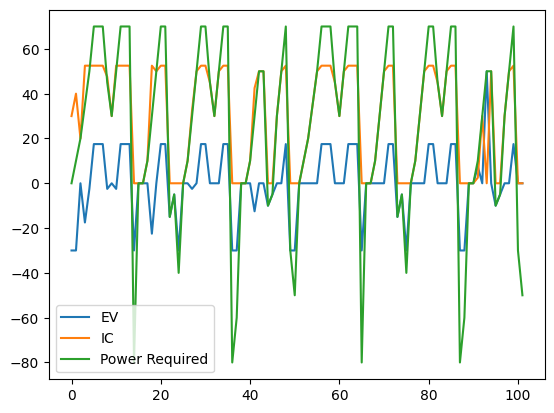

In [80]:
results = np.reshape(res.x,(3,-1)).T
EV = results[:,0]*EV_out_eff - results[:,1]*EV_in_eff
IC = results[:,2]*IC_eff

plt.plot(range(intervals),np.stack((EV,IC),1))
plt.plot(range(intervals),Ps)

plt.legend(['EV','IC','Power Required'])

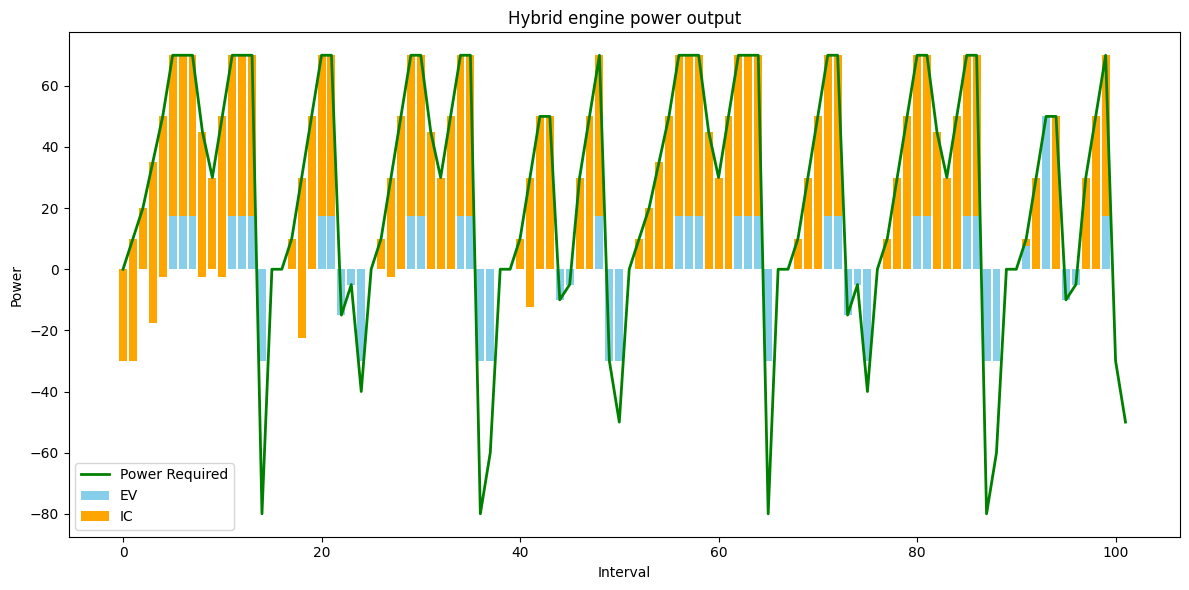

In [81]:
# Create the stacked bar plot
fig, ax = plt.subplots(figsize=(12, 6))

x = range(intervals)
width = 0.8

ax.bar(x, EV, width, label='EV', color='skyblue')
ax.bar(x, IC, width, bottom=EV, label='IC', color='orange')

# Plot the Power Required line
ax.plot(x, Ps, color='green', linewidth=2, label='Power Required')

ax.set_xlabel('Interval')
ax.set_ylabel('Power')
ax.set_title('Hybrid engine power output')
ax.legend()

plt.tight_layout()
plt.show()